## 1. Pytorch CNN MNIST Tutorial

<blockquote>
<b>Deeperence 멱살 스터디는...</b><br>
숭실대학교 머신러닝 소모임 Deeperence에서 진행하는 'Vision AI 멱살 스터디'는 처음 비전 인공지능에 입문하신 분들을 대상으로 한달간 세 가지 태스크(Classification, Detection, Segmentation)를 속성으로 경험시켜 드리는 스터디입니다. 이름 그대로 멱살을 잡아끄는 듯한 초밀착 멘토링으로 가려운 곳을 시원하게 긁어 드립니다. (이 핸즈온 튜토리얼은 Deeperence, 강남 캐글스터디 초급to고급, 제 <a href = "https://brstar96.github.io/">개인 블로그</a>에 연재됩니다.)<br><br>
<i>Written by Myeong-Gyu.LEE, 2019-11-20</i>
</blockquote>

안녕하세요, Deeperence 멱살 스터디 첫 번째 시간엔 Deep learning의 'Hello, world!'와도 같은 MNIST 손글씨 분류 문제를 풀어 보도록 하겠습니다. 선형 회귀를 갓 마치고 오신 분들께서 가장 헷갈려 하시는 부분이 고차원 이미지 데이터 핸들링인데요, 이번 시간에 ①MNIST 데이터를 다뤄 보며 1차원 그레이 스케일 이미지에 대해 이해하고, ②[KaKR 3rd 차종분류 대회](https://www.kaggle.com/c/2019-3rd-ml-month-with-kakr)의 데이터셋을 활용해 3차원 RGB 이미지에 대해 이해하는 시간을 가져 보겠습니다. 

MNIST 데이터셋은 국내는 물론 해외 머신러닝 커뮤니티에서 오랜 시간 사랑받고 연구에 활용되어 왔습니다. MNIST는 1980년대 미국 국립표준기술연구소에서 수집한 6만 개 훈련 이미지, 그리고 1만 개의 테스트 이미지로 구성되어 있습니다. MNIST 데이터셋은 또한 Numpy array 형태로 다양한 머신러닝 프레임워크들에서 기본 제공하고 있습니다. 

MNIST 데이터셋을 활용한 손글씨 분류 문제는 0부터 9까지의 클래스를 가진 다량의 손글씨 이미지 데이터들을 학습한 후 들어오는 테스트 이미지에 대해 0~9 사이의 분류 결과를 예측하는 것입니다. 이번 노트북에서는 이미지 데이터의 구조와 함께 CNN 훈련을 위해 어떻게 이 데이터를 핸들링할지에 초점을 맞추어 스터디를 진행해 보도록 하겠습니다. 

<u><b>▶튜토리얼을 시작하기 전, 이 Colab Notebook의 사본을 개인 드라이브에 복사하신 후 사본으로 재접속해 주세요!</b><br>
<u><b>▶튜토리얼을 시작하기 전, Google Colab 상단의 메뉴 중 런타임->런타임 유형 변경에서 하드웨어 가속기를 GPU로 설정해 주세요!</b>
<center><img src='http://drive.google.com/uc?export=view&id=1A53ZszYoOeND9m2pT5ymXgM6dZeEK2QR' /><br></u><center>

### 1.1 필요한 라이브러리 로드하기
먼저, 기본적인 라이브러리들을 로드해 주겠습니다. `torch.cuda.get_device_name(0)`는 현재 사용 가능한 CUDA device의 이름을 표시해줍니다.

In [0]:
import itertools, os, argparse
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

torch.cuda.get_device_name(0)
use_cuda = torch.cuda.is_available() # return false if cannot use GPU

### 1.2 학습 데이터 표준화하기
이 이후에 진행할 차종분류 튜토리얼에서도 다루겠지만, 일반적으로 머신 러닝에 사용하는 숫자형 데이터는 <b>표준화(Standardization)</b>해주는 것이 좋습니다. 비전 태스크에서 많이 사용하는 Z-score Standardization은 우리가 사용할 학습 데이터가 [중심극한정리](https://ko.wikipedia.org/wiki/%EC%A4%91%EC%8B%AC_%EA%B7%B9%ED%95%9C_%EC%A0%95%EB%A6%AC)를 따라 정규분포를 따른다는 가정을 배경으로 깔고 있습니다. 각 집단, 즉 이미지 각각이 가진 평균과 표준편차가 제각각이라면 모수<i>(모집단의 평균이나 표준편차와 같이 모집단을 설명하는 어떤 값. 여기서 모집단은 train set을 의미합니다.)</i>에 왜곡이 발생할 것입니다. 각각의 이미지는 정규분포 성향을 띌 수 있지만, 각 이미지의 모수를 확실히 통일하고 어느 정도 동등한 조건에서 학습하기 위해 저희의 데이터셋이 표준정규분포(Standard Normal Distribution)를 따르게 할 필요가 있습니다. 

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Clt_in_action.gif/400px-Clt_in_action.gif' />
<br><i>▲ 중심극한정리에 따라, 매우 불규칙한 분포도 충분히 많은 수를 더하면 결국 정규분포로 수렴합니다.</i></center><br><br>


서로 다른 모양의 정규분포를 표준화하는 방법은 <u>평균을 0으로, 표준편차를 1로</u> 만들어 주는 것입니다. 개별 이미지에서 해당 train set 전체의 평균을 빼고 표준 편차로 나누어 주면 되는 것이죠. 개별 이미지에서 전체 데이터셋의 평균을 빼 준 것은 0으로 수평이동을 한 것과 같습니다. 거기에 모집단의 표준편차로 나누어 주었으므로 개별 데이터의 표준 편차도 1이 되는 것이죠. 

하지만 아무리 MNIST라고 해도 모든 데이터셋에 대한 모수를 구하는 것은 꽤 귀찮기 때문에, 저희는 미리 다른 분이 구한 평균과 표준편차값을 사용하겠습니다. 다행히도 표준화는 파이토치가 함수로 제공해 줍니다.

<blockquote>
<b>-- NOTE --</b><br>
ImageNet과 같은 거대한 이미지 데이터셋은 누군가 미리 구한 평균과 표준편차가 있습니다. (means = [0.485, 0.456, 0.406], 
stds = [0.229, 0.224, 0.225]) 이 수치들을 사용해 아래 코드처럼 standardize를 수행할 수 있습니다.  
</blockquote>

MNIST의 mean은 0.1307, std는 0.3081입니다. 
유명한 데이터셋(cifar10 등)의 mean과 std를 직접 구하고 싶다면 이 [디스커션](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)의 dlmacedo님이 올린 답변을 참고해 보세요.  

In [0]:
# standardization code
standardization = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

`transforms.Compose`를 사용하면 저희가 지정해 준 mean과 std값을 `DataLoader`에 편리하게 넘겨줄 수 있습니다. 위에서 정의한 `standardization`를 `DataLoader`함수에 인자로 넘겨 줌으로서 학습을 위한 <u>데이터를 전처리하고 로드하는 과정을 동시에 수행</u>할 수 있습니다. 저희의 데이터는 이제 표준화되었습니다.

<blockquote>
<b>-- NOTE --</b><br>
이 튜토리얼에서는 단순히 Standardization을 수행하는 목적으로만 transforms.Compose를 사용했지만, 더 복잡한 모델에서는 resize, data augmentation 과정 등에 사용하기도 합니다. 차종분류 튜토리얼에서 더 자세히 다뤄 보겠습니다.
</blockquote>

In [0]:
# Load MNIST Dataset from torchvision.datasets
train_dataset = datasets.MNIST(root='./data/', train=True, transform=standardization, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=standardization)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21413533.39it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 320059.41it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5203230.45it/s]                           
8192it [00:00, 131272.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


`torchvision` 모듈의 `datasets.MNIST`클래스는 코드 한줄로 편하게 MNIST를 불러올 수 있도록 파이토치가 제공해 주는 내장 함수입니다. `datasets.MNIST`의 인자로 들어간 `train=True`는 True/False 여부에 따라 각각 다른 set(train/test)을 받을 수 있도록 해 줍니다. <br><br>


<img src='http://drive.google.com/uc?export=view&id=1NyyfCjSshvzeJAHU4WYXH-7jeX5dHuJZ' /><br>


머신 러닝의 학습 과정에서는 아래와 같이 두 개 내지는 세 개의 set으로 분리해 학습하는 것이 일반적입니다. train set과 validation set으로 나누는 이유는 저희가 <u>train set을 통해 만든 모델이 결과를 얼마나 잘 예측하는지 그 성능을 가늠해 보기 위해서</u>입니다. 머신 러닝의 목적은 다량의 데이터를 통해 패턴을 찾고, 그 패턴으로 하여금 처음 보는 unseen data, 즉 test data에 대해 좋은 성능을 내도록 하는 것입니다. 하지만 train set으로 저희의 모델을 평가하게 되면 이미 모델이 정답을 알고 있기 때문에 공정한 평가를 할 수 없겠죠. 따라서 모델이 보지 못한 validation set을 따로 두어 학습이 다 끝난 후 평가를 해야 합니다. 

<b>더 어렵게 설명하자면,</b> 우리는 먼저 모수 추정, 즉 학습을 위한 데이터셋을 만듭니다. 이때 사용하는 set이 train set이죠. train set 내의 종속 변수값을 얼마나 잘 예측하는지 평가하는 것을 In-sample testing이라고 하고, 보통 `train_loss`와 `train_accuracy`로 어림잡아 평가합니다. 하지만 학습의 궁극적인 목표는 학습에 사용되지 않은 표본에 대해 종속 변수의 값을 잘 추정하는(prediction) 것이므로, 학습에 쓰이지 않은 데이터 집합의 종속변수 값을 얼마나 잘 예측하는지 평가할 필요가 있습니다. 이것을 표본 외 성능 검출(out-of-sample testing)이라고 하며, 대표적으로 <b>교차 검증(Cross validation)</b>방식이 제일 유명합니다. 교차 검증을 수행하는 방법은 크게 `K-fold cross validation`, `Holdout validation` 두 가지로 나뉘죠.

<b>가장 쉬운 설명</b>을 위해 비유를 하자면, 우선 train set은 저희가 수능 공부를 할 때 열심히 푸는 교과서나 수능특강 같은 문제집이 되겠습니다. validation set은 공부한 내용을 평가해 보는 모의고사가 되겠고, test set은 수능시험이 되겠습니다. 따라서 test set은 모델은 물론 사람도 못본 데이터여야 모델의 진정한 성능을 알 수 있게 되는 것이죠. 

이렇게 train과 test set을 나누어 사용하게 되면 <u>모델을 튜닝하는 데 힌트를 얻을 수 있게 됩니다</u>. train_acc는 높은데 validation_acc가 낮다면 모델이 train set에 overfitting되었다고 표현할 수 있겠죠. 그렇다면 우리는 모델에 regularization을 가하거나 epoch을 줄이는 등의 조치를 취할 수 있습니다. 

<img src='http://drive.google.com/uc?export=view&id=1ROextOTnlEFk-6IEXRLhAyLMtxm9Y5sT' /><br>

<blockquote>
<b>-- NOTE --</b><br>
Validation set과 Test set은 간혹 사람에 따라 뜻을 혼용해서 쓰기도 합니다. <br> 하지만 기억해야 할 것은, 어쨌든 우리는 Train set으로 모델을 훈련하고, Validation으로 모의고사를 보고, Test로 수능을 본다는 것이지요. 수능특강을 열심히 푼 후(Train) 바로 수능(test)를 볼 수도 있지만, 제일 안전한 것은 모의고사(validation)를 꾸준히 보며 나의 지식을 테스트해보는 것이겠죠. validation과 test의 목적을 구분하는 것은 코드의 맥락에 따라 파악해야 합니다. 

</blockquote>

### 1.3 학습 데이터 살펴보기
학습 데이터를 본격적으로 모델에 넣어 주기 전, MNIST 데이터셋의 구조를 살펴 보도록 합시다. 

In [0]:
print("Number of training data : ", len(train_dataset))
print("Number of test data : ", len(test_dataset))

Number of training data :  60000
Number of test data :  10000


개수만 보아서는 데이터의 형태를 알 수 없으므로, 데이터를 하나만 뽑아서 더 자세히 살펴 보겠습니다.

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  5


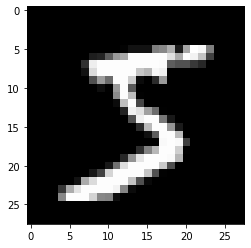

In [0]:
import torchvision
import matplotlib.pyplot as plt

one_image, label = train_dataset[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)

MNIST 데이터셋의 개별 데이터 한 개는 이미지의 정보를 담고 있는 1차원 tensor과 그 이미지의 int형 라벨로 구성되어 있음을 알 수 있습니다. 이미지의 각 픽셀 값은 0~1 사이의 float형으로 저장되어 있으며, 1에 가까울수록 흰색을, 0에 가까울 수록 검은색으로 표현됩니다. 파이토치는 다른 딥러닝 프레임워크와는 다르게 <b>N(batch_size) x C(channel) x W(width) x H(height) 순서</b>로 이미지 데이터를 처리합니다. 그래서 `one_image.shape`의 결과가 `[1, 28, 28]`로 나타나는 것이죠. 

`plt.imshow`를 통해 이미지를 띄우는 과정에서, `imshow`에 들어가는 이미지 데이터는 1채널 grayscale이나 3(RGB)채널 또는 4(RGBA)채널만이 들어갈 수 있습니다. 따라서 `[W, H]`나 `[W, H, 3]`, `[W, H, 4]`형태만을 넣어줄 수 있죠. Numpy의 `squeeze()`함수는 차원 중 사이즈가 1인 것을 찾아 해당 차원을 제거해 줍니다. Numpy array의 형상을 바꾸는 세 가지 함수 `reshape`, `squeeze`, `expand_dim`는 이미지 데이터 핸들링에 자주 사용되기 때문에 알아두면 편리합니다.

#### 1.4 DataLoader 만들기
`train_dataset`과 `test_dataset`을 통해 MNIST 데이터셋을 불러온 후 해야 할 것은 `DataLoader`를 만드는 것입니다.

In [0]:
# Create Data Loader (input pipeline)
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

데이터셋의 크기가 VRAM(그래픽카드 메모리)에 다 올라올 수 있을 정도로 크지 않다면 모든 데이터셋을 메모리에 다 올려두고 학습을 진행해도 됩니다. MNIST 데이터셋 정도의 사이즈는 충분히 GPU에 모두 올려도 상관없지만, 실전에서 쓰이는 데이터셋은 크기가 매우 방대하기 때문에 <b>batch</b>라는 개념을 이용해 학습을 진행하게 됩니다. 하드웨어의 성능상 한계로 인해 OOM(Out-of-Memory) 에러가 발생할 뿐만 아니라 모든 데이터에 대해 Gradient를 구하는 것이 상당히 비효율적이기 때문입니다. 배우는 김에 배치 단위로 학습을 진행해 보겠습니다.

batch는 우리말로 직역하면 '집단', 또는 '한 회분'이라는 뜻으로, <u>전체 데이터를 일정 장수로 나누어 묶은 단위</u>를 의미합니다. 즉 <u>한 step을 진행할 때 처리할 데이터 묶음</u>이라는 뜻이죠. 여기서 용어를 다시 한번 짚고 넘어가겠습니다. 

* <b>Epoch :</b> 전체 Train set에 대해 forward 및 backward step을 모두 한 번씩 진행한 상태를 의미합니다. 
* <b>batch_size :</b> forward 및 backward step을 진행할 때 한번에 얼만큼의 데이터씩 넣어 줄지를 의미합니다. batch_size = 64는 한번에 64장의 이미지 데이터가 들어감을 의미합니다. 
  * forward step : 입력에서 출력까지 레이어를 거치며 출력하는 과정을 의미합니다.
  * backward step : loss를 구한 후 backpropagation을 통해 네트워크의 맨 끝에서 시작 레이어까지 반복적으로 연쇄 법칙(chain rule)을 따라 gradient를 전파하는 과정입니다.
* <b>iterations :</b> batch_size 단위로 몇번의 forward, backward step을 진행했는지 그 횟수를 의미합니다. 전체 data size는 batch_size x iteration이 되며, 보통 전체 데이터의 길이를 batch_size로 나누어 반복문을 돌려 줍니다.

위에서 언급한 내용들을 편하게 함수 호출을 통해 간단히 사용할 수 있도록 구현된 것이 `torch.utils.data.DataLoader` 함수입니다. `torch.utils.data.DataLoader`의 원형은 아래와 같이 세 부분으로 이루어져 있습니다. 공식 코드의 주석에서는 이렇게 설명하고 있네요. 'Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.'

~~~
class Dataloader(Dataset):
  
  # Initialize your data, download, etc.
  def __init__(self):

  # return one item on the index
  def __getitem__(self, index)

  # return the data length
  def __len__(self):
~~~

1. `__init__(self)`
  - 데이터셋 다운로드, read data 등의 작업을 수행하는 부분입니다. 
  - 파라미터 인자를 받아 변수에 할당해 줍니다. 
  - 데이터셋의 파일 리스트를 받아 로드하고, 존재 유무를 확인합니다. 이를 통해 데이터셋을 파싱해 줍니다. 
2. `__getitem__(self, index)` 
  - 특정 인덱스에 해당하는 아이템을 넘겨 주는 부분입니다. 학습 데이터의 일부를 
  슬라이싱해 리턴합니다. 
  - `__getitem__`함수가 실행되면 데이터셋의 index를 받게 되고, 이를 통해 학습 데이터의 file path를 읽을 수 있습니다. (`list(self.data[index].keys())`를 통해 확인해볼 수 있습니다.)
3. `__len__(self)` : 학습용 dataset의 리스트 길이(length)를 넘겨 주는 부분입니다. 

`shuffle`은 데이터셋으로부터 랜덤샘플링을 할 것인지 여부를 bool값으로 지정해줄 수 있습니다. `num_workers=4`는 4개의 멀티스레드를 이용해 데이터를 읽어올 것임을 의미합니다. 

### 1.5. 네트워크 만들기

이제 간단한 CNN(Convolution Neural Network) 네트워크를 만들어 봅시다!
<img src='http://drive.google.com/uc?export=view&id=1n2wQqJc-KRUgZSkO5k_7702ACaVVQ2Kq' /><br>

모델을 만들기 위해 가장 먼저 해야 할 일은 class를 하나 만들고 `__init__`을 정의하는 것입니다. <b>`__init__`을 통해 네트워크에서 사용할 모든 모듈들을 초기화 해두고 `forward`함수에서 호출해 네트워크의 레이어를 쌓을 수 있도록</b> 해야 합니다. 먼저, `Conv2d`와 `MaxPool2d`가 어떤 인자들을 받아 어떤 역할을 수행하는지 확인해 봅시다.

#### 1.5.1 Convolution 이해하기

CNN에서 사용하는 Convolution 연산은 왜 강력한 것일까요? 그 전에, convolution 연산은 왜 수행하는 것일까요? 

컴퓨터 비전에서는 <u>이미지로부터 특정 feature(특징)를 뽑아내기 위해 n x n kernel(=filter)이라고 부르는 2차원 배열을 사용</u>합니다. 이 커널을 사용해 전체 이미지의 모든 영역을 훑어 내면 원하는 특정 feature만을 추출해 낼 수 있습니다. 직관적으로 이해가 가지 않으실 테니, 코드 예시를 함께 보시죠. 

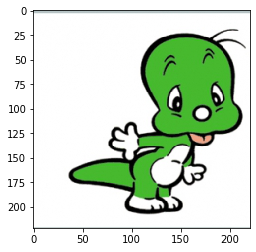

In [0]:
import imageio, cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_arr = imageio.imread('https://img.seoul.co.kr/img/upload/2012/12/12/SSI_20121212185722_V.jpg')
plt.imshow(img_arr)

귀여운 둘리의 모습입니다. 저는 지금 유명한 필터 중 하나인 [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator)를 사용해 이 둘리 이미지로부터 edge feature만 뽑아 내고 싶습니다. 일반적으로 edge는 픽셀 간의 차이를 통해 구할 수 있습니다. 이미지의 픽셀값 변화가 갑자기 커지는 부분을 찾기 위해선 연속된 픽셀값에 대해 미분을 수행하면 되죠. 하지만 이미지는 디지털 데이터이기 때문에, X축과 Y축 각각의 방향을 기준으로 다음 픽셀에서 현재 픽셀의 값을 빼 주는 것이 기본적인 엣지 검출 알고리즘의 동작 원리입니다. X방향과 Y 방향에 대한 미분 마스크(행렬)를 생성한 후 convolution 연산을 수행해 주면 X 방향의 미분 마스크는 세로 방향에 대한 엣지를 검출할 것이고, Y 방향 미분 마스크는 가로 방향의 엣지를 검출하겠죠. 이산화(discrete)된 근사값으로 얻어내긴 했지만, 비전 분야에서는 이렇게 얻어낸 결과를 <u>Gradient</u>라고 부릅니다. 이 X축과 Y축에 대한 Gradient들을 구하면 저희가 원하는 엣지를 찾아낼 수 있는 것이죠.

shape of gx_kernel :  (3, 3)
shape of original image :  (222, 221, 3)
shape of feature map :  (222, 221, 3)


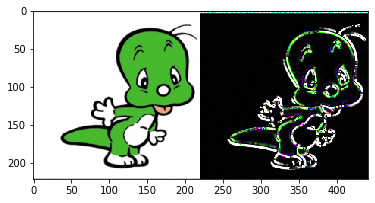

In [0]:
# Create Sobel kernel
gx_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
gy_kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

# Apply kernel to image
edge_gx = cv2.filter2D(img_arr, -1, gx_kernel)
edge_gy = cv2.filter2D(img_arr, -1, gy_kernel)

# Print results
print("shape of gx_kernel : ", gx_kernel.shape)
print("shape of original image : ", img_arr.shape)
print("shape of feature map : ", (edge_gx+edge_gy).shape)
merged_hardcoded = np.hstack((img_arr, edge_gx+edge_gy))
plt.subplot()
plt.imshow(merged_hardcoded)

우리는 소벨 필터를 이용해 둘리 이미지로부터 엣지 feature를 찾는 데 성공했습니다. 원본 둘리 이미지에 소벨 필터를 적용해 얻은 오른쪽 이미지를 <u>feature map</u>이라고 부릅니다. 둘리 이미지는 RGB 3채널로 구성되어 있고, 각 채널에 대해 소벨 필터를 적용했으므로 feature map은 3개가 생기게 됩니다. 이 세 개의 feature map을 [가산 혼합](https://ko.wikipedia.org/wiki/RGB_%EA%B0%80%EC%82%B0%ED%98%BC%ED%95%A9)하여 얻은 것이 오른쪽 둘리 테두리 이미지가 되겠습니다. 

이를 통해, 이미지로부터 찾고 싶은 성분이 있을 때 필터의 종류가 다양할수록 여러 개의 feature map이 생긴다는 사실을 알 수 있습니다. <u>이미지에는 윤곽, 텍스쳐 등의 다양한 정보들이 포함되어 있고, 기존에는 이미지로부터 이러한 특정 feature를 뽑아 내기 위해 커널을 손수 디자인</u>해야 했습니다. (대표적으로 차선 검출에 자주 사용되는 steerable filter 등이 있습니다.) 하지만 이 과정은 대단히 비효율적이기 때문에 <u>필터의 성분을 자동으로 찾아 주는 CNN 알고리즘</u>이 각광을 받게 된 것이죠. 학습을 거듭할수록, 우리의 네트워크 속 커널들은 인풋 이미지에 대해 더 잘 필터링을 수행할 수 있게 될 것입니다. 즉, 알아서 학습한 수많은 필터들을 기반으로 강력한 feature extraction 능력을 갖추게 되는 것이죠. 

이미지는 상당한 고차원 데이터이기 때문에, 쓸모 없는 정보 또한 많이 포함되어 있습니다. 한 번쯤은 들어 보셨을 <b>차원의 저주 현상</b>(train 샘플 각각이 수천 심지어 수백만 개의 특성을 가지고 있을 때 훈련을 느리게 할 뿐만 아니라, 최적의 솔루션을 찾기 어렵게 만드는 현상)을 줄이기 위한 목적으로서의 convolution 또한 중요한데요, CNN의 핵심은 <b>원본 이미지와 필터를 갖고 convolution 연산을 수행해 중요한 feature를 detect한 후 maxpooling이라는 압축 과정을 거쳐 또 한번 중요한 feature만을 남기는 것</b>입니다. 이 과정을 거침으로서 쓸모없는 데이터가 제거되고 중요한 feature만이 남게 되는 것이죠.

- `nn.Conv2d`를 따라가 보면 다음과 같은 인자들을 확인할 수 있습니다. 
  ~~~
  def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                  padding=0, dilation=1, groups=1,
                  bias=True, padding_mode='zeros'):
  ~~~

  - `in_channels`는 input channel의 수를 의미하며, MNIST는 그레이스케일이므로 1을 인자로 넘겨 줍니다. 
  - `out_channels`는 `Conv2d` 연산의 결과로 나오는 채널 수를 의미합니다. 
  - `kernel_size`는 인풋 이미지에 대해 얼만큼의 시야를 갖는 window로 convolution 연산을 수행할지 결정합니다. <i>(보통 3 x 3이나 5 x 5 사이즈를 사용합니다.)</i>
  - `stride` : 이미지를 횡단할 때 kernel의 step size를 결정해 줍니다. 기본값은 1입니다. <i>(더 많은 영역을 보고 싶거나, Max Pooling과 비슷하게 이미지를 다운샘플링할 때 2 또는 더 큰 사이즈의 stride 사이즈를 지정해 주기도 합니다.)</i>
  - `padding` : Convolution 연산을 수행할 샘플의 테두리를 어떻게 처리할지를 결정합니다. 패딩이 적용된 convolution 연산은 input과 output의 차원이 동일하게 유지되고, 패딩이 적용되지 않으면 kernel size가 1보다 큰 경우 테두리의 일부가 잘릴 수 있습니다. <i>(보통 패딩 영역에는 0으로 채우는 zero padding을 적용합니다.)</i>
<img src='http://drive.google.com/uc?export=view&id=1nRoGSfNrlYYUVfBb7BfQ2r_0L3HJ3MGC' /><br>
(위 그림은 파란색의 input에 패딩을 주고 3 x 3 convolution 연산을 stride_size 1로 계산해 초록색 output을 만드는 과정을 시각화한 것입니다.)




#### 1.5.2 MaxPooling2D 이해하기
<u>MaxPooling은 convolution을 통해 나온 feature에 대해 특정 윈도우 사이즈만큼 돌며 제일 큰 값</u>을 가져옵니다. 아래 이미지가 잘 설명해 주고 있네요. MaxPooling2D는 채널 한개 단위로 실행되므로, 아웃풋 채널 사이즈는 굳이 정해줄 필요가 없습니다. 

<img src='http://drive.google.com/uc?export=view&id=1I452-wXunTmdsL6WK2vLYmtHRs2YO2m-' /><br>


- `nn.MaxPool2d`는 따라가 보면 `F.max_pool2d`를 리턴하게 되어 있습니다. 또다시 따라가 보면 다음과 같은 인자들을 확인할 수 있습니다. 핵심 인자들의 쓰임새는 `Conv2d` 레이어와 동일합니다. 

  ~~~
  def _max_pool2d(input, kernel_size, stride=None, padding=0, dilation=1,
                  ceil_mode=False, return_indices=False):
  ~~~

#### 1.5.3 모델 클래스 만들기

모델을 클래스 단위로 정의하는 이유는 객체 지향 프로그래밍의 장점을 십분 활용하기 위해서입니다. 모델 클래스를 instantiate해 다양한 인풋과 파라미터가 적용된 여러 모델을 만들고 성능을 평가할 때 편리하기 때문입니다. 붕어빵을 구울 때 제빵틀을 만들고 굽는다면 금방금방 붕어빵을 찍어낼 수 있겠죠.

<img src='http://drive.google.com/uc?export=view&id=1n2wQqJc-KRUgZSkO5k_7702ACaVVQ2Kq' /><br>

이 네트워크는 LeNet-5라는 역사적인 CNN 모델입니다. Yann LeCun 교수님이 우편번호와 수표의 필기체를 인식하기 위한 용도로 개발한 고전적인 CNN 구조이죠. 기존까지 사용하던 무거운 Fully-connected neural network가 가진 한계를 개선하기 위해 등장했습니다. 총 세 개의 convolution 레이어와 2개의 sub-sampling layer(Maxpool2d), 2개의 fully-connected layer로 구성되어 있네요.

In [0]:
from collections import OrderedDict

class simple_CNN(nn.Module): 

    def __init__(self): # 네트워크에서 사용할 모듈들을 초기화
        super(simple_CNN, self).__init__() # 항상 nn.Module을 상속받고 시작합니다. 

        self.convnet = nn.Sequential(OrderedDict([
        ('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1, padding=2)), # 1채널의 인풋 이미지를 받아 6채널 아웃풋을 만들되, 5 x 5 사이즈의 커널을 사용합니다. [6, 28, 28]
        ('relu1', nn.ReLU()), # ReLU activation layer [6, 28, 28]
        ('S2', nn.MaxPool2d(kernel_size=2)), # Maxpool2d [6, 14, 14]
        ('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)), # conv1과 MaxPool2d을 거쳐 나온 6채널의 아웃풋을 인풋으로 받아 16채널 아웃풋을 만들되 5 x 5 사이즈의 커널을 사용합니다. [16, 10, 10]
        ('relu3', nn.ReLU()), # ReLU activation layer [16, 10, 10]
        ('S4', nn.MaxPool2d(kernel_size=2)), # Maxpool2d [16, 5, 5]
        ('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=1)), # conv2와 MaxPool2d을 거쳐 나온 16채널의 아웃풋을 인풋으로 받아 120채널 아웃풋을 만들되 5 x 5 사이즈의 커널을 사용합니다. [1, 120]
        ('relu5', nn.ReLU()) # ReLU activation layer [1, 120]
        ]))

        self.fc = nn.Sequential(OrderedDict([
        ('F6', nn.Linear(120, 84)), # 1 x 120을 인풋으로 받아 1 x 84 결과물을 만듭니다. [1, 84]
        ('relu6', nn.ReLU()), # ReLU activation layer [1, 84]
        ('F7', nn.Linear(84, 10)), # 1 x 84를 인풋으로 받아 1 x 10 결과물을 만듭니다. [1, 10]
        ('sig7', nn.LogSoftmax(dim=-1)) # 클래스별로 모델이 예측한 log 확률을 반환합니다. (dim=-1은 마지막 차원을 가리킵니다.)
        ]))

    # 모델 네트워크 레이어 쌓기
    def forward(self, x):
        output = self.convnet(x)
        output = output.view(x.size(0), -1)
        output = self.fc(output)
        return output


파이토치의 `torch.nn` 패키지는 `Module`들을 구현해 놓은 패키지입니다. `Module`은 입력을 받아 모델로 하여금 출력을 생성하도록 하고 학습 가능한, 즉 미분 가능한 weight를 갖는 Neural Network Layers의 집합입니다. `Linear`, `ReLU`, `Conv2d` 등이 포함되어 있죠.

위에서 모델을 만들기 위해 가장 먼저 해야 할 일은 class를 하나 만들고 `__init__`을 정의하는 것이라고 말씀드렸습니다. `__init__`에 레이어를 초기화하는 과정에서 `nn.Sequential`에 레이어를 담아 두면 이후 `forward()`에서 레이어를 쌓을 때 편리하게 블록 단위로 쌓을 수 있습니다. 모델이 복잡해질수록 효과가 뛰어나죠. 

`Softmax`와 `nn.LogSoftmax`레이어는 무슨 역할을 하는 레이어일까요? 직관적으로 설명하자면, <u>K 사이즈의 벡터를 0~1 사이의 값으로 찌그러뜨리는 역할을 함으로서 확률로 변환해 주는 역할</u>을 합니다. 아래 이미지를 보시면 이해가 더 쉬울지도 모르겠네요. 1.6절의 NOTE3에서 이야기를 이어 나가겠지만, <u>pmf(확률질량함수)에서 모든 확률의 합은 1이므로, 모든 클래스 확률의 총합은 1이 되어야 합니다.</u> 

<img src='http://drive.google.com/uc?export=view&id=1IqeHCjTY8r7d-CryH05swDZ6PdhbDfaj' /><br>

`nn.LogSoftmax`는 `softmax`연산을 수행해 확률값을 얻은 후 로그를 씌워 준 것입니다. <u>그렇다면 로그를 씌워 주는 이유는 무엇일까요?</u>

1. <u>연산 속도를 높이고</u>(multiple joint probabilities에 로그를 씌운 것은 개별 확률에 로그를 씌운 값들의 합으로 단순화할 수 있죠. ) <u>Gradient optimization을 편리하게 수행</u>하기 위해서입니다.
2. 컴퓨터는 제한된 부동 소수점 표현 방식을 사용하기 때문에 log를 씌워 줌으로서 log scale로 정규화를 하지 않으면 결합확률을 구하는 과정에서 결과가 0에 가까워지게 됩니다. 즉 <u>값이 너무 커지거나(overflow) 0에 가까워지는 문제(underflow)를 방지함으로서 연산의 안정성</u>을 높여 줍니다. 

이 예제에서는 LogSoftmax를 구해준 후 아래 `train()`함수에서 호출한 `nll_loss`(Negative Log Likelihood) 에 넘겨 loss를 구했습니다. 하지만 `LogSoftmax`를 사용하지 않고 맨 마지막 레이어의 아웃풋을 바로 `CrossEntropyLoss`에 넘겨주는 것이 레이어를 하나 덜 쌓을 수 있으므로 성능상 조금 이점이 있습니다. 

<u>머신러닝은 베이즈 이론에 기반해 Likelihood를 최대화하는 방향(Maximum likelihood)으로 학습을 진행</u>합니다. <u>입력값(CNN에서는 학습 이미지) X와 모델의 파라미터 θ(CNN에서는 kernel weight)가 주어졌을 때 정답 Y가 나타날 사후확률을 최대화하는 θ를 찾는 것</u>이죠. 따라서 X와 Y는 고정되어 있는 상태이며, 모든 데이터 샘플은 <u>i.i.d condition(Independent and identically distributed condition, 즉 동일한 모집단 내에서 동일한 분포를 따르는 데이터들을 독립적으로 샘플링하는 상황)을 따른다고 가정</u>합니다. 여기에 위에 설명한 것처럼 연산의 속도와 안정성을 높여 주기 위해 log를 씌워 주는 것이죠. 

이렇게 모델링하면 우리가 가정하는 확률모델이 정규분포일 경우 중심극한정리에 따라 θ 추정에 사용하는 <u>sample space의 크기가 커질수록 진짜 train set의 모수에 수렴하는 특성</u>을 갖게 됩니다. 때문에 머신러닝에서 MLE(Maximum likelihood estimation) 기법을 자주 사용하는 것이죠. 하지만 <u>sample space에 모델의 성능이 큰 영향</u>을 받기 때문에, 최근 이를 보완하는 다양한 기법들이 제안되고 있습니다. 

<center><img src='http://drive.google.com/uc?export=view&id=1Fw8wHcKiS9jbdZJAD5f45PoiKfca3qhN' /><br></center>

<u>베이즈 이론에서 likelihood를 최대화하는 것은 두 분포 사이의 거리, 즉 train data와 모델 분포의 거리를 최소화하는 것</u>과 같습니다. 기억이 가물가물하시겠지만 베이즈 이론과 함께 의사가 환자의 CT사진을 보고 종양에 대해 암인지 아닌지를 판별하는 상황을 떠올려 봅시다. 만약 의사의 likelihood가 크지 않다면 암을 제대로 검진할 수 없을 것이고, 속된 말로 돌팔이 소리를 들을 것입니다. 100% 암인지 아닌지 잘은 모르지만, 많은 경험을 갖고 있는 의사라면 암을 정확히 검진할 확률이 100%에 수렴하겠죠. 

아무튼 다시 돌아와서, <u>log likelihood를 최대화하는 것은 negative log likelihood를 minimize하는 것</u>과 같습니다. 때문에 `nll_loss`에 모델이 예측한 값과 정답 값을 넘겨 줌으로서 loss를 구해야 하는 것이죠.

In [0]:
model = simple_CNN() # Define model
if use_cuda:
  model.cuda() # send model to device. (CPU or GPU, depending on hardware status)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # Define optimizer

위에서 만들었던 `simple_CNN` 클래스를 이용해 `model`이라는 모델 인스턴스를 만들었습니다. 이제 우리의 모델이 Gradient Descent 알고리즘을 이용해 변수 공간을 탐색할 수 있도록 Optimizer를 정의해 주도록 하겠습니다. <u>딥러닝에서의 최적화는 Optimizer과 Gradient descent 알고리즘을 이용해 loss가 최소가 되는 지점을 찾는 과정을 의미</u>합니다. 학습이라는 것은 곧 이 loss가 최소가 되는 지점에서의 weight값을 찾는 것이죠. 아무튼, 제일 만만하지만 의외로 굉장히 자주 쓰이는 SGD(Stochastic gradient descent) optimizer를 정의해 주겠습니다. SGD는 손실 함수의 기울기를 계산한 후 `lr`(learning rate)을 곱한 값으로 기존 가중치를 갱신합니다. 무작정 기울기 방향으로 이동하기 때문에 탐색 경로가 비효율적일 뿐만 아니라 한참을 탐색하게 되죠. 이 Optimizer는 Adam, AdaGrad 등 다양한 종류가 존재하지만 잘 모르겠다면 일단 SGD나 Adam부터 적용해 보는 것을 추천합니다. 

파이토치가 제공하는 SGD optimizer는 오리지널 SGD 알고리즘처럼 세월아 네월아 최적화를 수행하지 않습니다. momentum 개념이 추가되어 보다 빠르게 최적화를 수행하죠. `lr`인자는 최적화를 수행할 스텝 사이즈를 의미하고, `momentum`은 일종의 관성처럼 현재 그래디언트의 방향을 결정할 때 과거 그래디언트의 방향을 얼마나 사용할지 정해 주는 파라미터입니다. 보다 자세한 내용은 [여기](https://tensorflow.blog/2017/03/22/momentum-nesterov-momentum/)를 참고해 주세요.

<blockquote>
<b>-- NOTE --</b><br>
Optimizer는 상황과 데이터에 따라 이것저것 종류와 파라미터를 바꾸어 가며 실험해 보아야 하는 hyperparameter입니다. 마침 누군가 <a href = "https://ruder.io/optimizing-gradient-descent/">optimizer의 종류와 성능에 대해 비교한 포스팅</a>이 있네요. 
</blockquote>


### 1.6 train과 test 루틴 정의하기
학습 데이터 로드, 모델 정의와 optimizer를 정의해준 후 해야 할 것은 training과 test입니다. 우선 train 함수부터 만들어 보겠습니다. <br>




#### 1.6.1 Train

In [0]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad() # set the gradients to zero before starting backpropragation
        output = model(data) # model prediction
        loss = F.nll_loss(output, target) # calculate negative log likelihood
        loss.backward() # calculate gradients 
        optimizer.step() # update gradients
        if batch_idx % 100 == 0: # print train loss per every 100 batch_idx.
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

`trian`함수 맨 윗줄의 `model.train()` 구문은 저희가 위에서 만든 `model`를 학습 모드로 실행할 것임을 의미합니다. <u>이렇게 명시적으로 표시해 주어야 validation 단계에서 backpropagation을 통한 weight 수정이 발생하지 않습니다.</u> 모의고사를 보는 중에 컨닝을 하는 일은 없어야 하기 때문이죠. 

위에서 언급드린 것처럼, 학습은 한 에폭 동안 여러 gradient descent step을 반복하며 진행됩니다. 저희의 모델은 위에서 만들었던 `train_loader`의 길이를 `batch_size` 개수로 나눈 횟수(`batch_idx`)만큼 돌면서 `data`와 `target`을 갖고 오차를 구해 가중치를 업데이트하게 됩니다. `data`는 이미지 데이터이고, `target`은 해당 이미지 데이터의 정답 클래스 라벨이 되겠습니다. 

<u>데이터를 받은 후 반복문에서 제일 먼저 해야 할 것은 `optimizer.zero_grad()`를 통해 그래디언트를 0으로 초기화해 주는 것</u>입니다. 파이토치는 `.backward()`를 호출할 때마다 그래디언트를 누적하기 때문입니다. 

초기 가중치, 그러니까 첫 번째 step의 conv layer 가중치는 가우시안 분포를 따르는 랜덤값들로 채워지므로, `data`의 첫 번째 인덱스 이미지는 conv 레이어를 거치며 의미없는 쓰레기 값을 갖게 됩니다. 따라서 모델의 분류 결과인 `output` 또한 엉뚱한 클래스로 나오게 되겠죠. 

그래서 바로 아랫줄의 `F.nll_loss`함수에 모델이 예측한 클래스값 `output`과 정답값 `target`을 넣어 Negative Log Likelihood를 구한 후 `loss.backward()`를 호출하고, `optimizer.step()`을 연이어 호출함으로서 모델의 파라미터를 업데이트해 줍니다. <u>`loss.backward()`는 모델의 매개 변수에 대한 loss의 gradient를 계산하고, `optimizer.step()`을 호출함으로서 이 매개 변수가 갱신</u>됩니다. 이것이 학습이 수행되는 '한 step'인 거죠.

<blockquote>
<b>-- NOTE 1 --</b><br>
왜 특정 probability mass function(pmf)로 레이어들을 초기화해야 할까요? 그 이유는 <u>대다수의 머신 러닝은 확률 모형</u>이기 때문입니다. 머신 러닝의 목적은 어떤 확률모델(가우스, 베르누이 등등...)을 써서라도 추정 확률이 1에 수렴하도록 하는 것이며, 이때 train set의 정확한 확률분포는 모르지만 중심극한정리에 따라 대강 정규분포를 따를 것이라고 가정하는 것입니다. 이 가정을 바탕으로 <b>train set의 확률분포를 가우시안 분포로 초기화한 우리의 모델로 하여금 잘 추정하게 하는 것이 핵심 목표</b>입니다.<br><br>이때 손실함수로 negative log likelihood를 쓰게 되면 우리가 만들고자 하는 모델에 대해 다양한 확률분포를 가정할 수 있게 됩니다. 손실 함수 중 하나인 cross entropy는 두 확률분포 사이의 차이를 재는 함수이지만 비교 대상 확률 분포의 종류를 특정하지 않기 때문입니다. 가우시안 분포로 모델을 초기화했다면 Cross entropy 손실함수가 하는 일은 우리가 가진 train dataset과 모델이 가진 가우시안 분포 사이의 차이를 최소화하게 됩니다. <i>(가우시안 분포로 모델의 확률분포를 가정한 경우 Mean squared error과 본질적으로 동일해 cross entropy 대신 MSE를 사용하기도 합니다.)</i> <br><br>

<center><img src='http://drive.google.com/uc?export=view&id=14DlbZH8MTQuSb0LyVVJ8X44x_iqDQ7zQ' width=300 /></center><br>
</blockquote>

<blockquote>
<b>-- NOTE 2 --</b><br>
확률론에서 주로 다루는 확률변수(Random variable)는 연속확률변수와 이산확률변수 크게 두 가지로 나눌 수 있습니다. <br><br>
1. <b>확률변수(Random variable) : </b>확률적인 과정에 따라 값이 결정되는 변수로, 같은 확률공간에 정의된 여러 확률 변수에 대해 이들의 조건부 확률이나 독립 여부를 결정 가능한 변수입니다. 확률공간, 즉 Probability space란 전체 measure가 1인 공간을 의미하며, 보통 확률공간의 measure는 확률을 정의합니다. measure, 즉 '측도'란 특정 부분 집합에 일종의 크기를 부여해 계산할 수 있게 하는 함수를 의미합니다. <br>
2. <b>연속확률변수(Continuous random variable) :</b> 체중, 온도, 키 등과 같이 유한한 구간을 정해 두어도 소수점 무한대 자리까지의 측정치를 갖는 경우입니다. 즉 확률변수가 취할 수 있는 값은 일정한 구간 내의 실수로서, 그 '수가 무한한 경우'를 연속확률변수라고 부릅니다. <br>
3. <b>이산확률변수(Discrete random variable) : </b>주사위를 던질 때와 같이 확률변수가 취할 수 있는 값의 수가 유한하거나 무한해도 '셀 수 있는 경우'의 확률변수를 이산확률변수라고 부릅니다. <br><br>
이 두 가지의 확률변수를 통해 연속 확률 분포(Continuous probability distribution, 대표적으로 정규분포)와 이산 확률 분포(Discrete probability distribution, 대표적으로 이항분포)를 정의할 수 있게 되죠. 하지만, 이 개념을 머신 러닝으로 끌고 오기 위해선 <b>Probability mass function</b>에 대해 알아야 합니다.<br>

참고 자료 : https://datascienceschool.net/view-notebook/4d74d1b5651245a7903583f30ae44608/
</blockquote>

<blockquote>
<b>-- NOTE 3 --</b><br>
1. <b>확률질량함수(Probability mass function, pmf) :</b> 어떤 discrete random variables에 대한 확률 모델(probability model)을 의미합니다. sample space를 구성하는 각각의 outcome마다 총합이 1인 확률을 부여한 것입니다. 한 개의 동전을 두 번 던지는 시행에서 앞면이 나올 수 있는 횟수를 Random variable X라고 하면, X로 나올 수 있는 값은 앞면이 아예 나오지 않는 0, 한번 나오는 1, 두 번 나오는 2이며, 이때 각 확률은 P(X=0)=1/4, P(X=1)=2/4, P(X=2)=1/4이 됩니다. 이렇듯 pmf는 이산확률변수에 대한 확률분포를 나타내는 함수입니다. <br>
2. <b>확률밀도함수(Probability density function, pdf) : </b>확률밀도함수가 정의된 구간 내에 연속확률변수 X가 포함될 확률이 1임을 정의하는 함수입니다. 즉, 특정 구간에 대해 연속확률변수 X가 포함될 확률은 확률밀도함수를 구간에 대해 정적분한것과 같습니다. 

더 자세한 내용 참고 : https://bskyvision.com/387 
</blockquote>




In [0]:
# Start Training
epoch = 30
train(epoch)

Train Epoch: 30 [0/60000 (0%)]	Loss: 2.290109
Train Epoch: 30 [6400/60000 (11%)]	Loss: 2.259969
Train Epoch: 30 [12800/60000 (21%)]	Loss: 1.715970
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.482743
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.305575
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.382473
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.210351
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.158792
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.098416
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.061257


#### 1.6.2 Test

Test를 수행하기 위해 모델을 eval모드로 변환해 줍니다. 과연 몇 %의 정확도를 얻을 수 있을까요?

In [0]:
model.eval()
correct = 0
for data, target in test_loader:
    if use_cuda:
            data = data.cuda()
            target = target.cuda()
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 95.22%


나쁘지 않은 결과를 얻었네요! 다음 핸즈온 튜토리얼에서는 KaKR 3rd 자동차 차종분류 대회 데이터셋을 활용해 더 복잡한 이미지 데이터를 다루어 보겠습니다.


<blockquote>
<b>참고</b><br>
아래는 Pytorch의 공식 MNIST 튜토리얼 풀코드입니다. 지금까지 배웠던 내용들을 되새김하며 훑어 보시기 바랍니다. 설명이 대단히 길었지만, 코드는 생각했던 것보다 짧네요 :)<br>
<a href = "https://github.com/pytorch/examples/blob/master/mnist/main.py">https://github.com/pytorch/examples/blob/master/mnist/main.py</a>
</blockquote>

